In [1]:
# training and testing catalogs
# hume, based on Rachel's code

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rcParams as param
from IPython.display import display, Latex

from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
from keras import backend as K

import tensorflow as tf 
from tensorflow import keras

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import TensorBoard

import random
import cv2

import csv
import os
import math
from scipy.stats import norm
import os
import re
import GPUtil
#
import time
#time
from time import process_time
from time import time

start_process = process_time()
start_time = time()

tf.random.set_seed(982369253487)

In [3]:
# filenames and paths

num_cat = 200
num_rot = 100

num_epochs = 40
num_dense = 1
num_conv = 5
train_percent = 0.80
train_per = int(100 * train_percent)

iplot = 0 # 0 plot, 1 don't

timet = int(time())

filepathindata = "/Users/hume/manu/velocities/Improved_Large-scale-flows/Prog/data/"
filepath = filepathindata + "catalogs/CF3-OuterRim-CF3grouplike/"

post_name = (f'%d epochs %d conv %d' %  (num_epochs, num_conv, train_per))

filepathint = "rotated/rotated_" + (f'%d_' % num_cat) + (f'%d' % num_rot) + "/"

filepathin = filepath + filepathint

label1 = (f'%d catalogs ' % num_cat) + (f'with %d rotations ' % num_rot)
label2 = (f'%d-cat_' % num_cat) + (f'%d-rot_' % num_rot)

label1_pre = ('Predicted_i ' + label1 + post_name)
label1_BF = ('BF_i ' + label1 + post_name)
label1_res = ('Residuals ' + label1 + post_name)


#filepathin = filepath + "rotated/uncut"          # One catalog rotated 3k times
#filepathin = filepath + "rotated/all_rotated_10"  # 300 catalog rotated 10 times each
#filepathin = filepath + "rotated/all_rotated_100" # 300 catalog rotated 100 times each

filepathinbf = filepath + "rotated/BF"

print(filepath)
print(filepathint)

print(label1_pre)
print(label1_BF)
print(label1_res)

timet = int(time())
#NAME = ("%d-conv-%d-dense-%d-epochs-%d" % (num_conv, num_dense, num_epochs, timet)
#tensorboard = TensorBoard(log_dir = 'logs-BF/{}'.format(NAME))
#print(NAME)

NAME = (label2 + "{}-epochs_{}-conv_{}_{}".format(num_epochs, num_conv, train_per, timet))
print(NAME)

tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

# to visualize, with terminal go to  the directory where "logs/" directory is 
# type "tensorboard --logdir=logs"
# it will give you a website such as "http://localhost:6006/"
# open the URL in a brouser



/Users/hume/manu/velocities/Improved_Large-scale-flows/Prog/data/catalogs/CF3-OuterRim-CF3grouplike/
rotated/rotated_200_100/
Predicted_i 200 catalogs with 100 rotations 40 epochs 5 conv 80
BF_i 200 catalogs with 100 rotations 40 epochs 5 conv 80
Residuals 200 catalogs with 100 rotations 40 epochs 5 conv 80
200-cat_100-rot_40-epochs_5-conv_80_1657338266


In [4]:
cutoff = 11100
#this is the length I'm cutting off the data just arbitrarily when I'm using multiple catalogs
#but here since i'm only using one it doesn't matter 
time1 = process_time()
time5 = time()

master_rshift = []
master_dist_mod = [] #errors added on 
master_glat = [] 
master_glon = [] 
bulkflows = [] 
#I use this to determine the shortest length of data when using varied catalogs 

print(filepathin)

for files in os.listdir(filepathin):
#    print(filepathin + files)

#    data = np.load(filepathin + "/" + files)
    data = np.load(filepathin + files)

    master_rshift.append(data['redshift'][:cutoff])
    master_dist_mod.append(data['distm'][:cutoff] + data['distmerr'][:cutoff])
    master_glat.append(data['glat'][:cutoff])
    master_glon.append(data['glon'][:cutoff])
    bulkflows.append(data['bulkflow'])
    
master_bulkflows = np.array(bulkflows) #cutoff is number of files 

#I scale the data to be between 0 and 1 here, where I am scaling it by the 
#largest value of all the data, as opposed to scaling each by 
#the maximum of that array respectively 
#not sure if this is the best approach? 

redshift = np.array(master_rshift)/np.max(np.concatenate(np.array(master_rshift))) 
distm = np.array(master_dist_mod)/np.max(np.concatenate(np.array(master_dist_mod)))
glat = np.array(master_glat)/np.max(np.concatenate(np.array(master_glat)))
glon = np.array(master_glon)/np.max(np.concatenate(np.array(master_glon)))

print(len(redshift))
x_max = max(master_bulkflows[:,0])
y_max = max(master_bulkflows[:,1])
z_max = max(master_bulkflows[:,2])
bf_max = max(x_max, y_max, z_max)

master_bulkflows_scaled = [] 
for filebf in master_bulkflows: 
    master_bulkflows_scaled.append(filebf/np.array([bf_max,bf_max,bf_max]))
    
#Here I am preparing the data into its training and testing sets 

X = np.stack([redshift,distm,glat,glon],axis=-1) #used to be -1
y = np.array(master_bulkflows_scaled)

X_train,X_test = (X[:int(len(X)*train_percent)], X[int(len(X)*train_percent)::])
y_train,y_test = (y[:int(len(y)*train_percent)], y[int(len(y)*train_percent)::])

print(" Loading files in %6.2f s CPU  %6.2f s" % 
      (process_time() - time1, time() - time5))



/Users/hume/manu/velocities/Improved_Large-scale-flows/Prog/data/catalogs/CF3-OuterRim-CF3grouplike/rotated/rotated_200_100/
20000
 Loading files in 124.51 s CPU  2163.28 s


In [5]:
# the input, which is the size of the amount of arrays in each catalog
# with 4 being the size of each of those arrays (rshift, distmod, glat, glon)
time2 = process_time()
time3 = time()

print(f'num_conv = %d' % num_conv)
inputs = tf.keras.Input(shape=X_train.shape[1:])
#print(inputs)

#here, it's like adding a first layer, where the (inputs) means you're putting the last thru this one 
x = tf.keras.layers.Conv1D(64, 16, activation='relu')(inputs)
#print(x.shape)
#here you're doing the same thing, putting the last (x) in this new layer (x2) 
#the input shape is from the shape that the previous (x) CONV layer outputs 
#I don't know quite what the shape *means*, but you have to basically have the 
#input shape of a layer be whatever shape the last one output 
x2 = tf.keras.layers.Conv1D(32, 8, input_shape=x.shape[1:], activation='tanh')(x) # tanh
#print(x2.shape[1:])
x3 = tf.keras.layers.Conv1D(32, 6, input_shape=x2.shape[1:], activation='relu')(x2)

if num_conv > 3:
    x4 = tf.keras.layers.Conv1D(32, 6, input_shape=x3.shape[1:], activation='tanh')(x3)
    x5 = tf.keras.layers.Conv1D(32, 6, input_shape=x4.shape[1:], activation='relu')(x4)

if num_conv > 5:
    x6 = tf.keras.layers.Conv1D(32, 6, input_shape=x5.shape[1:], activation='tanh')(x5)
    x7 = tf.keras.layers.Conv1D(32, 4, input_shape=x6.shape[1:], activation='relu')(x6)

if num_conv > 7:
    x8 = tf.keras.layers.Conv1D(32, 4, input_shape=x5.shape[1:], activation='tanh')(x7)
    x9 = tf.keras.layers.Conv1D(32, 4, input_shape=x6.shape[1:], activation='relu')(x8)

#now to put in our last layer, the dense layer, we have to flatten it to get our 3D single arrays 
#Flatten is itself a type of layer 
if num_conv == 3:
    xf = tf.keras.layers.Flatten()(x3)
if num_conv == 5:
    xf = tf.keras.layers.Flatten()(x5)
if num_conv == 7:
    xf = tf.keras.layers.Flatten()(x7)
if num_conv == 9:
    xf = tf.keras.layers.Flatten()(x9)


outputs = tf.keras.layers.Dense(3,activation='linear')(xf)

model1 = tf.keras.Model(inputs=inputs,outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model1.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

model1.fit(X_train, y_train, 
           epochs = num_epochs,
           validation_split = 0.3,
           callbacks = [tensorboard])

print(" training and testing in %6.2f s CPU  %6.2f s time" % 
      (process_time() - time2, time() - time3))
GPUtil.showUtilization()

num_conv = 5
Metal device set to: Apple M1


2022-07-08 23:20:30.008403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-08 23:20:30.009564: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/40


2022-07-08 23:20:50.327981: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-08 23:20:50.988437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


350/350 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.4635

2022-07-08 23:21:43.897605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


350/350 [==============================] - 61s 169ms/step - loss: 0.0683 - accuracy: 0.4635 - val_loss: 0.0554 - val_accuracy: 0.5598
Epoch 2/40
350/350 [==============================] - 52s 147ms/step - loss: 0.0435 - accuracy: 0.6298 - val_loss: 0.0396 - val_accuracy: 0.6596
Epoch 3/40
350/350 [==============================] - 50s 142ms/step - loss: 0.0292 - accuracy: 0.7121 - val_loss: 0.0316 - val_accuracy: 0.6998
Epoch 4/40
350/350 [==============================] - 61s 175ms/step - loss: 0.0216 - accuracy: 0.7653 - val_loss: 0.0272 - val_accuracy: 0.7333
Epoch 5/40
350/350 [==============================] - 159s 453ms/step - loss: 0.0169 - accuracy: 0.7962 - val_loss: 0.0235 - val_accuracy: 0.7563
Epoch 6/40
350/350 [==============================] - 784s 2s/step - loss: 0.0139 - accuracy: 0.8207 - val_loss: 0.0208 - val_accuracy: 0.7760
Epoch 7/40
350/350 [==============================] - 49s 141ms/step - loss: 0.0112 - accuracy: 0.8428 - val_loss: 0.0189 - val_accuracy: 0.79

In [6]:
y_pred = model1.predict(X_test)


  1/125 [..............................] - ETA: 1:12

2022-07-09 00:36:42.039162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/125 [==============================] - 15s 117ms/step


-245.71320662662 261.28187627262787


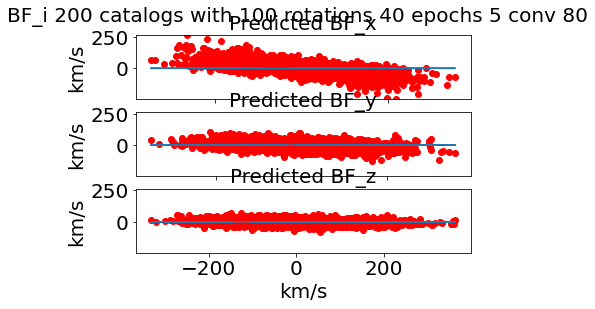

In [7]:
plt.rcParams['figure.figsize'] = [14, 20]
figure, axis = plt.subplots(3)

# put main title
figure.suptitle(label1_pre, fontsize=25)

# axis label size
for i in range(3):
    axis[i].tick_params(axis='x', labelsize=20)
    axis[i].tick_params(axis='y', labelsize=20)

y_min0 = min(y_pred[:,0]*bf_max - y_test[:,0]*bf_max)
y_min1 = min(y_pred[:,1]*bf_max - y_test[:,1]*bf_max)
y_min2 = min(y_pred[:,2]*bf_max - y_test[:,2]*bf_max)
y_max0 = max(y_pred[:,0]*bf_max - y_test[:,0]*bf_max)
y_max1 = max(y_pred[:,1]*bf_max - y_test[:,1]*bf_max)
y_max2 = max(y_pred[:,2]*bf_max - y_test[:,2]*bf_max)

y_min = min(y_min0, y_min1, y_min2)
y_max = max(y_max0, y_max1, y_max2)
print(y_min, y_max)

y_limit = [y_min, y_max]

axis[0].set_ylim(y_limit)
axis[1].set_ylim(y_limit)
axis[2].set_ylim(y_limit)

axis[0].plot(y_test[:,0]*bf_max,y_pred[:,0]*bf_max - y_test[:,0]*bf_max,'ro')
axis[0].plot(y_test[:,0]*bf_max,y_test[:,0]*bf_max - y_test[:,0]*bf_max)

axis[0].set_title('Predicted BF_x', fontsize = 20)
axis[0].axes.xaxis.set_ticklabels([])
axis[0].set_ylabel('km/s', fontsize = 20)

axis[1].plot(y_test[:,1]*bf_max,y_pred[:,1]*bf_max - y_test[:,1]*bf_max,'ro')
axis[1].plot(y_test[:,1]*bf_max,y_test[:,1]*bf_max - y_test[:,1]*bf_max)

axis[1].set_title('Predicted BF_y', fontsize = 20)
axis[1].axes.xaxis.set_ticklabels([])
axis[1].set_ylabel('km/s', fontsize = 20)

axis[2].plot(y_test[:,2]*bf_max,y_pred[:,2]*bf_max - y_test[:,2]*bf_max,'ro')
axis[2].plot(y_test[:,2]*bf_max,y_test[:,2]*bf_max - y_test[:,2]*bf_max)

axis[2].set_title('Predicted BF_z', fontsize = 20)
axis[2].set_xlabel('km/s', fontsize = 20)
axis[2].set_ylabel('km/s', fontsize = 20)

labfig = label1_BF
figure.suptitle(labfig, fontsize=20)

plt.show()


In [8]:
x_preds = y_pred[:,0]*bf_max
y_preds = y_pred[:,1]*bf_max
z_preds = y_pred[:,2]*bf_max

bulkflows_pred = np.sqrt(x_preds**2 + y_preds**2 + z_preds**2)
bulkflows_pred_xy = np.sqrt(x_preds**2 + y_preds**2)
bulkflows_pred_xz = np.sqrt(x_preds**2 + z_preds**2)
bulkflows_pred_yz = np.sqrt(y_preds**2 + z_preds**2)

x_true = y_test[:,0]*bf_max
y_true = y_test[:,1]*bf_max
z_true = y_test[:,2]*bf_max

bulkflows_true = np.sqrt(x_true**2 + y_true**2 + z_true**2)
bulkflows_true_xy = np.sqrt(x_true**2 + y_true**2)
bulkflows_true_xz = np.sqrt(x_true**2 + z_true**2)
bulkflows_true_yz = np.sqrt(y_true**2 + z_true**2)

print(len(x_preds), len(bulkflows_true), len(bulkflows_pred_xz))

zz_BF = np.sum(np.sqrt(bulkflows_true**2 + bulkflows_pred**2))
zz_BF1 = np.sum(np.sqrt((bulkflows_true - bulkflows_pred)**2))

zz_BF_x = np.sum(np.sqrt(x_true**2 + x_preds**2))
zz_BF1_x = np.sum(np.sqrt((x_true - x_preds)**2))

zz_BF_y = np.sum(np.sqrt(y_true**2 + y_preds**2))
zz_BF1_y = np.sum(np.sqrt((y_true - y_preds)**2))

zz_BF_z = np.sum(np.sqrt(z_true**2 + z_preds**2))
zz_BF1_z = np.sum(np.sqrt((z_true - z_preds)**2))

lab1 = ('$\\frac{\sqrt{\\sum(BF^t - BF^p)^2}}{DoF} = %6.2f$') % (zz_BF1/len(bulkflows_true))
labx = ('$\\frac{\sqrt{\\sum(BF^t_x - BF^p_x)^2}}{DoF} = %6.2f$') % (zz_BF1_x/len(bulkflows_true))
laby = ('$\\frac{\sqrt{\\sum(BF^t_y - BF^p_x)^2}}{DoF} = %6.2f$') % (zz_BF1_y/len(bulkflows_true))
labz = ('$\\frac{\sqrt{\\sum(BF^t_z - BF^p_x)^2}}{DoF} = %6.2f$') % (zz_BF1_z/len(bulkflows_true))
display(Latex(lab1))
display(Latex(labx))
display(Latex(laby))
display(Latex(labz))



4000 4000 4000


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

-352.09856982673136 362.0772851885618
-245.71320662662 261.28187627262787
4000 4000


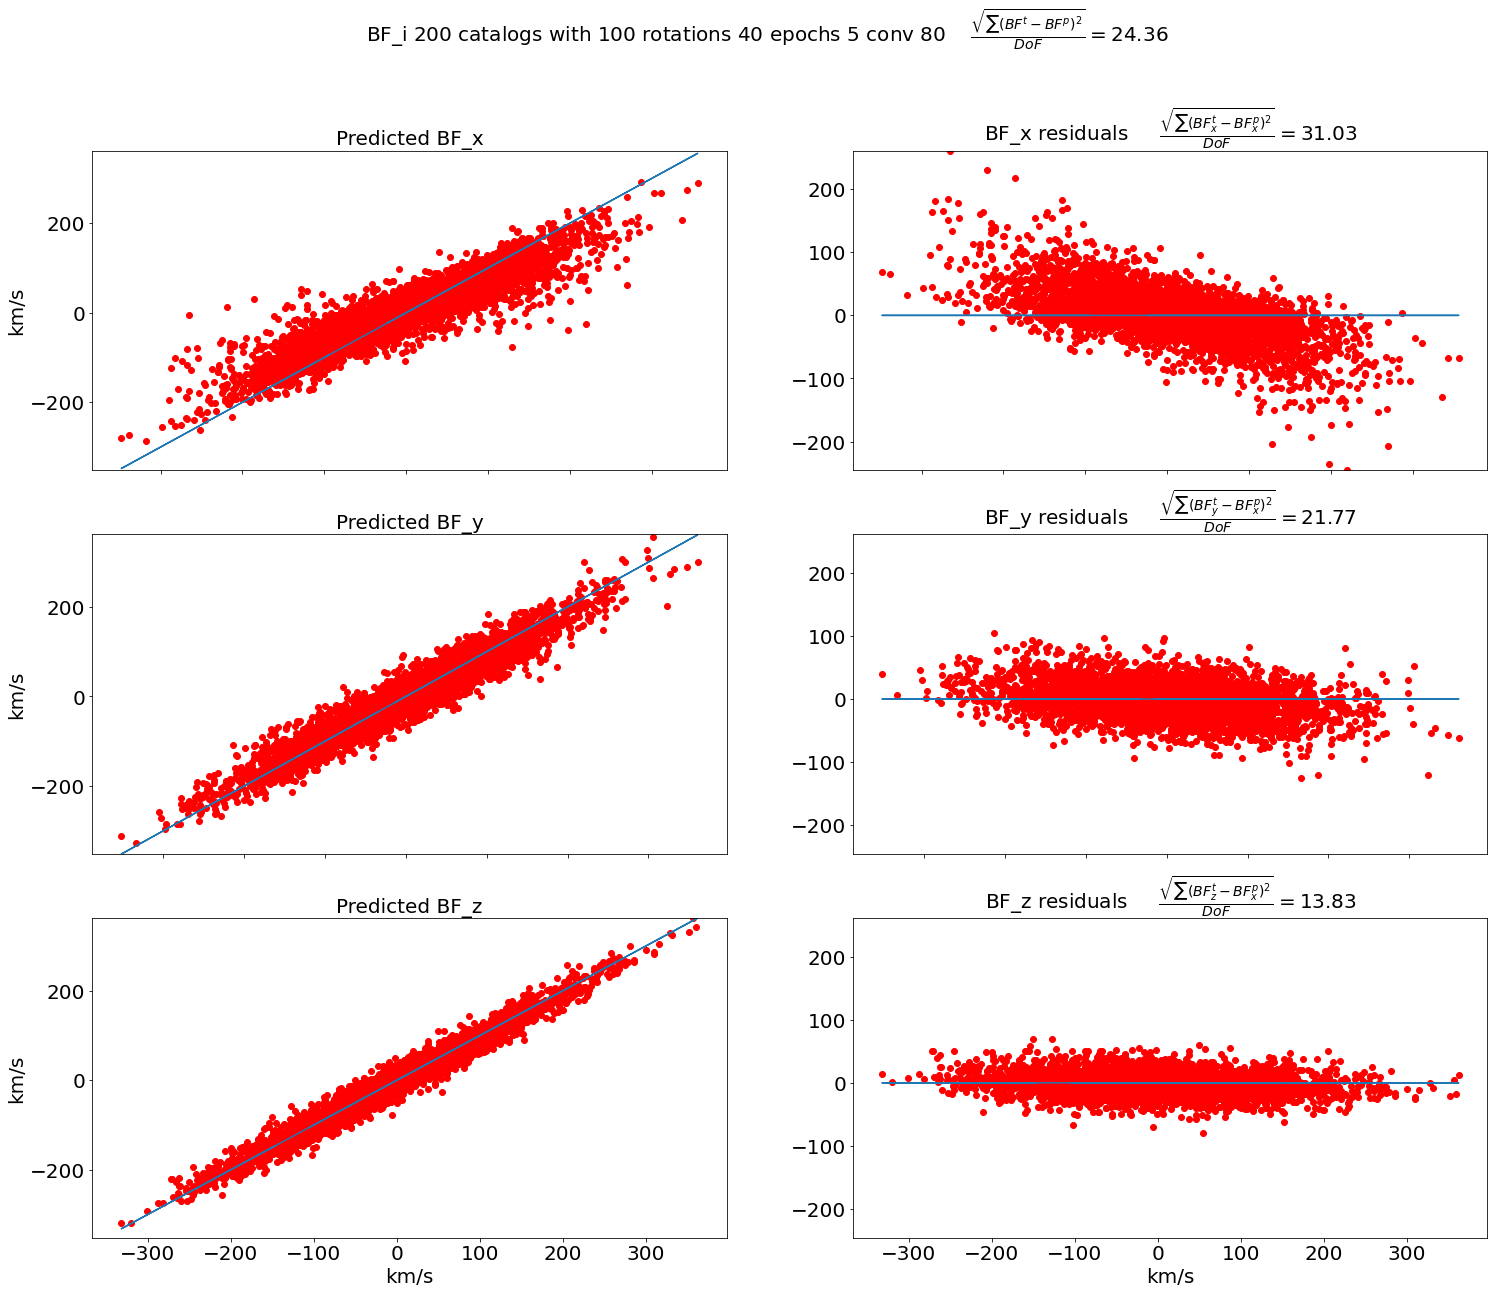

In [9]:
# Plot and save BF and BF residuals

plt.rcParams['figure.figsize'] = [25, 20]
figure, axis = plt.subplots(3,2)

# put main title
#figure.suptitle(label1_BF, fontsize=25)

# axis label size
for i in range(3):
    for j in range(2):
        axis[i,j].tick_params(axis='x', labelsize=20)
        axis[i,j].tick_params(axis='y', labelsize=20)

# plot test vs. predicted
        
y_min0 = min(y_test[:,0]*bf_max)
y_min1 = min(y_test[:,1]*bf_max)
y_min2 = min(y_test[:,2]*bf_max)
y_max0 = max(y_test[:,0]*bf_max)
y_max1 = max(y_test[:,1]*bf_max)
y_max2 = max(y_test[:,2]*bf_max)

y_min = min(y_min0, y_min1, y_min2)
y_max = max(y_max0, y_max1, y_max2)
print(y_min, y_max)
y_limit = [y_min, y_max]

axis[0, 0].set_ylim(y_limit)
axis[1, 0].set_ylim(y_limit)
axis[2, 0].set_ylim(y_limit)

axis[0,0].plot(y_test[:,0]*bf_max,y_pred[:,0]*bf_max, 'ro')
axis[0,0].plot(y_test[:,0]*bf_max,y_test[:,0]*bf_max)

axis[0,0].set_title('Predicted BF_x', fontsize = 20)
axis[0,0].axes.xaxis.set_ticklabels([])
axis[0,0].set_ylabel('km/s', fontsize = 20)

axis[1,0].plot(y_test[:,1]*bf_max,y_pred[:,1]*bf_max, 'ro')
axis[1,0].plot(y_test[:,1]*bf_max,y_test[:,1]*bf_max)

axis[1,0].set_title('Predicted BF_y', fontsize = 20)
axis[1,0].axes.xaxis.set_ticklabels([])
axis[1,0].set_ylabel('km/s', fontsize = 20)

axis[2,0].plot(y_test[:,2]*bf_max,y_pred[:,2]*bf_max , 'ro')
axis[2,0].plot(y_test[:,2]*bf_max,y_test[:,2]*bf_max)

axis[2,0].set_title('Predicted BF_z', fontsize = 20)
axis[2,0].set_xlabel('km/s', fontsize = 20)
axis[2,0].set_ylabel('km/s', fontsize = 20)

# plot test vs predicted residuals

y_min0 = min(y_pred[:,0]*bf_max - y_test[:,0]*bf_max)
y_min1 = min(y_pred[:,1]*bf_max - y_test[:,1]*bf_max)
y_min2 = min(y_pred[:,2]*bf_max - y_test[:,2]*bf_max)
y_max0 = max(y_pred[:,0]*bf_max - y_test[:,0]*bf_max)
y_max1 = max(y_pred[:,1]*bf_max - y_test[:,1]*bf_max)
y_max2 = max(y_pred[:,2]*bf_max - y_test[:,2]*bf_max)

y_min = min(y_min0, y_min1, y_min2)
y_max = max(y_max0, y_max1, y_max2)
print(y_min, y_max)

y_limit = [y_min, y_max]

axis[0, 1].set_ylim(y_limit)
axis[1, 1].set_ylim(y_limit)
axis[2, 1].set_ylim(y_limit)

axis[0,1].plot(y_test[:,0]*bf_max,y_pred[:,0]*bf_max - y_test[:,0]*bf_max,'ro')
axis[0,1].plot(y_test[:,0]*bf_max,y_test[:,0]*bf_max - y_test[:,0]*bf_max)

labelx = 'BF_x residuals' + '     ' + labx
axis[0,1].set_title(labelx, fontsize = 20)
axis[0,1].axes.xaxis.set_ticklabels([])
#axis[0,1].set_ylabel('km/s', fontsize = 20)

axis[1,1].plot(y_test[:,1]*bf_max,y_pred[:,1]*bf_max - y_test[:,1]*bf_max,'ro')
axis[1,1].plot(y_test[:,1]*bf_max,y_test[:,1]*bf_max - y_test[:,1]*bf_max)

labely = 'BF_y residuals' + '     ' + laby
axis[1,1].set_title(labely, fontsize = 20)
axis[1,1].axes.xaxis.set_ticklabels([])
#axis[1,1].set_ylabel('km/s', fontsize = 20)
#axis[1,1].axes.yaxis.set_ticklabels([])

axis[2,1].plot(y_test[:,2]*bf_max,y_pred[:,2]*bf_max - y_test[:,2]*bf_max,'ro')
axis[2,1].plot(y_test[:,2]*bf_max,y_test[:,2]*bf_max - y_test[:,2]*bf_max)

labelz = 'BF_z residuals' + '     ' + labz
axis[2,1].set_title(labelz, fontsize = 20)
axis[2,1].set_xlabel('km/s', fontsize = 20)
#axis[2,1].set_ylabel('km/s', fontsize = 20)
#axis[2,1].axes.yaxis.set_ticklabels([])

print(len(bulkflows_true), len(bulkflows_pred))
figure.suptitle(labfig, fontsize=25)
labfig = label1_BF + '    ' + lab1
figure.suptitle(labfig, fontsize=20)

plt.savefig('Plots/' + label1_BF + '.png')



In [10]:
if iplot == 2: 
    plt.rcParams['figure.figsize'] = [25, 20]
    figure, axis = plt.subplots(3,3)

    # put main title
    #figure.suptitle(label1_BF, fontsize=25)

    # axis label size
    for i in range(3):
        for j in range(3):
            axis[i,j].tick_params(axis='x', labelsize=20)
            axis[i,j].tick_params(axis='y', labelsize=20)

    # plot test vs. predicted

    y_min0 = min(y_pred[:,0]*bf_max)
    y_min1 = min(y_pred[:,1]*bf_max)
    y_min2 = min(y_pred[:,2]*bf_max)
    y_max0 = max(y_pred[:,0]*bf_max)
    y_max1 = max(y_pred[:,1]*bf_max)
    y_max2 = max(y_pred[:,2]*bf_max)

    y_min = min(y_min0, y_min1, y_min2)
    y_max = max(y_max0, y_max1, y_max2)
    print(y_min, y_max)
    y_limit = [y_min, y_max]

    axis[0, 0].set_ylim(y_limit)
    axis[1, 0].set_ylim(y_limit)
    axis[2, 0].set_ylim(y_limit)

    axis[0,0].plot(y_test[:,0]*bf_max,y_pred[:,0]*bf_max, 'ro')
    axis[0,0].plot(y_test[:,0]*bf_max,y_test[:,0]*bf_max)

    axis[0,0].set_title('Predicted BF_x', fontsize = 20)
    axis[0,0].axes.xaxis.set_ticklabels([])
    axis[0,0].set_ylabel('km/s', fontsize = 20)

    axis[1,0].plot(y_test[:,1]*bf_max,y_pred[:,1]*bf_max, 'ro')
    axis[1,0].plot(y_test[:,1]*bf_max,y_test[:,1]*bf_max)

    axis[1,0].set_title('Predicted BF_y', fontsize = 20)
    axis[1,0].axes.xaxis.set_ticklabels([])
    axis[1,0].set_ylabel('km/s', fontsize = 20)

    axis[2,0].plot(y_test[:,2]*bf_max,y_pred[:,2]*bf_max , 'ro')
    axis[2,0].plot(y_test[:,2]*bf_max,y_test[:,2]*bf_max)

    axis[2,0].set_title('Predicted BF_z', fontsize = 20)
    axis[2,0].set_xlabel('km/s', fontsize = 20)
    axis[2,0].set_ylabel('km/s', fontsize = 20)

    # plot test vs predicted residuals

    y_min0 = min(y_pred[:,0]*bf_max - y_test[:,0]*bf_max)
    y_min1 = min(y_pred[:,1]*bf_max - y_test[:,1]*bf_max)
    y_min2 = min(y_pred[:,2]*bf_max - y_test[:,2]*bf_max)
    y_max0 = max(y_pred[:,0]*bf_max - y_test[:,0]*bf_max)
    y_max1 = max(y_pred[:,1]*bf_max - y_test[:,1]*bf_max)
    y_max2 = max(y_pred[:,2]*bf_max - y_test[:,2]*bf_max)

    y_min = min(y_min0, y_min1, y_min2)
    y_max = max(y_max0, y_max1, y_max2)
    print(y_min, y_max)

    y_limit = [y_min, y_max]

    axis[0, 1].set_ylim(y_limit)
    axis[1, 1].set_ylim(y_limit)
    axis[2, 1].set_ylim(y_limit)

    axis[0,1].plot(y_test[:,0]*bf_max,y_pred[:,0]*bf_max - y_test[:,0]*bf_max,'ro')
    axis[0,1].plot(y_test[:,0]*bf_max,y_test[:,0]*bf_max - y_test[:,0]*bf_max)

    axis[0,1].set_title('BF_x residuals', fontsize = 20)
    axis[0,1].axes.xaxis.set_ticklabels([])
    #axis[0,1].set_ylabel('km/s', fontsize = 20)

    axis[1,1].plot(y_test[:,1]*bf_max,y_pred[:,1]*bf_max - y_test[:,1]*bf_max,'ro')
    axis[1,1].plot(y_test[:,1]*bf_max,y_test[:,1]*bf_max - y_test[:,1]*bf_max)

    axis[1,1].set_title('BF_y residuals', fontsize = 20)
    axis[1,1].axes.xaxis.set_ticklabels([])
    #axis[1,1].set_ylabel('km/s', fontsize = 20)
    #axis[1,1].axes.yaxis.set_ticklabels([])

    axis[2,1].plot(y_test[:,2]*bf_max,y_pred[:,2]*bf_max - y_test[:,2]*bf_max,'ro')
    axis[2,1].plot(y_test[:,2]*bf_max,y_test[:,2]*bf_max - y_test[:,2]*bf_max)

    axis[2,1].set_title('BF_z residuals', fontsize = 20)
    axis[2,1].set_xlabel('km/s', fontsize = 20)
    #axis[2,1].set_ylabel('km/s', fontsize = 20)
    #axis[2,1].axes.yaxis.set_ticklabels([])

    # plot test vs predicted residuals ij

    y_min0 = min(bulkflows_pred_xy - bulkflows_true_xy)
    y_min1 = min(bulkflows_pred_xz - bulkflows_true_xz)
    y_min2 = min(bulkflows_pred_yz - bulkflows_true_yz)
    y_max0 = max(bulkflows_pred_xy - bulkflows_true_xy)
    y_max1 = max(bulkflows_pred_xz - bulkflows_true_xz)
    y_max2 = max(bulkflows_pred_yz - bulkflows_true_yz)

    y_min = min(y_min0, y_min1, y_min2)
    y_max = max(y_max0, y_max1, y_max2)
    print(y_min, y_max)

    y_limit = [y_min, y_max]

    axis[0, 2].set_ylim(y_limit)
    axis[1, 2].set_ylim(y_limit)
    axis[2, 2].set_ylim(y_limit)

    axis[0,2].plot(bulkflows_true_xy, bulkflows_pred_xy - bulkflows_true_xy,'ro')
    axis[0,2].plot(bulkflows_true_xy, bulkflows_true_xy - bulkflows_true_xy)

    axis[0,2].set_title('xy residuals', fontsize = 20)
    axis[0,2].axes.xaxis.set_ticklabels([])
    #axis[0,2].set_ylabel('km/s', fontsize = 20)
    #axis[0,2].axes.yaxis.set_ticklabels([])

    axis[1,2].plot(bulkflows_true_xz, bulkflows_pred_xz - bulkflows_true_xz,'ro')
    axis[1,2].plot(bulkflows_true_xz, bulkflows_true_xz - bulkflows_true_xz)

    axis[1,2].set_title('xz residuals', fontsize = 20)
    axis[1,2].axes.xaxis.set_ticklabels([])
    #axis[1,2].set_ylabel('km/s', fontsize = 20)
    #axis[1,2].axes.yaxis.set_ticklabels([])

    axis[2,2].plot(bulkflows_true_yz, bulkflows_pred_yz - bulkflows_true_yz,'ro')
    axis[2,2].plot(bulkflows_true_yz, bulkflows_true_yz - bulkflows_true_yz)

    axis[2,2].set_title('yz residuals', fontsize = 20)
    axis[2,2].set_xlabel('km/s', fontsize = 20)
    #axis[2,2].set_ylabel('km/s', fontsize = 20)
    #axis[2,2].axes.yaxis.set_ticklabels([])

    from IPython.display import display, Latex

    print(len(bulkflows_true), len(bulkflows_pred))

    zz_BF = np.sum(np.sqrt(bulkflows_true**2 + bulkflows_pred**2))
    zz_BF1 = np.sum(np.sqrt((bulkflows_true - bulkflows_pred)**2))

    print(zz_BF1, len(bulkflows_true))
    lab1 = ('$\\frac{\sqrt{\\sum(BF_t - BF_p)^2}}{DoF} = %6.2f$') % (zz_BF1/len(bulkflows_true))
    #display(Latex(lab1))
    labfig = label1_BF + '    ' + lab1
    figure.suptitle(labfig, fontsize=25)

    plt.savefig('Plots/' + label1_BF + '.png')


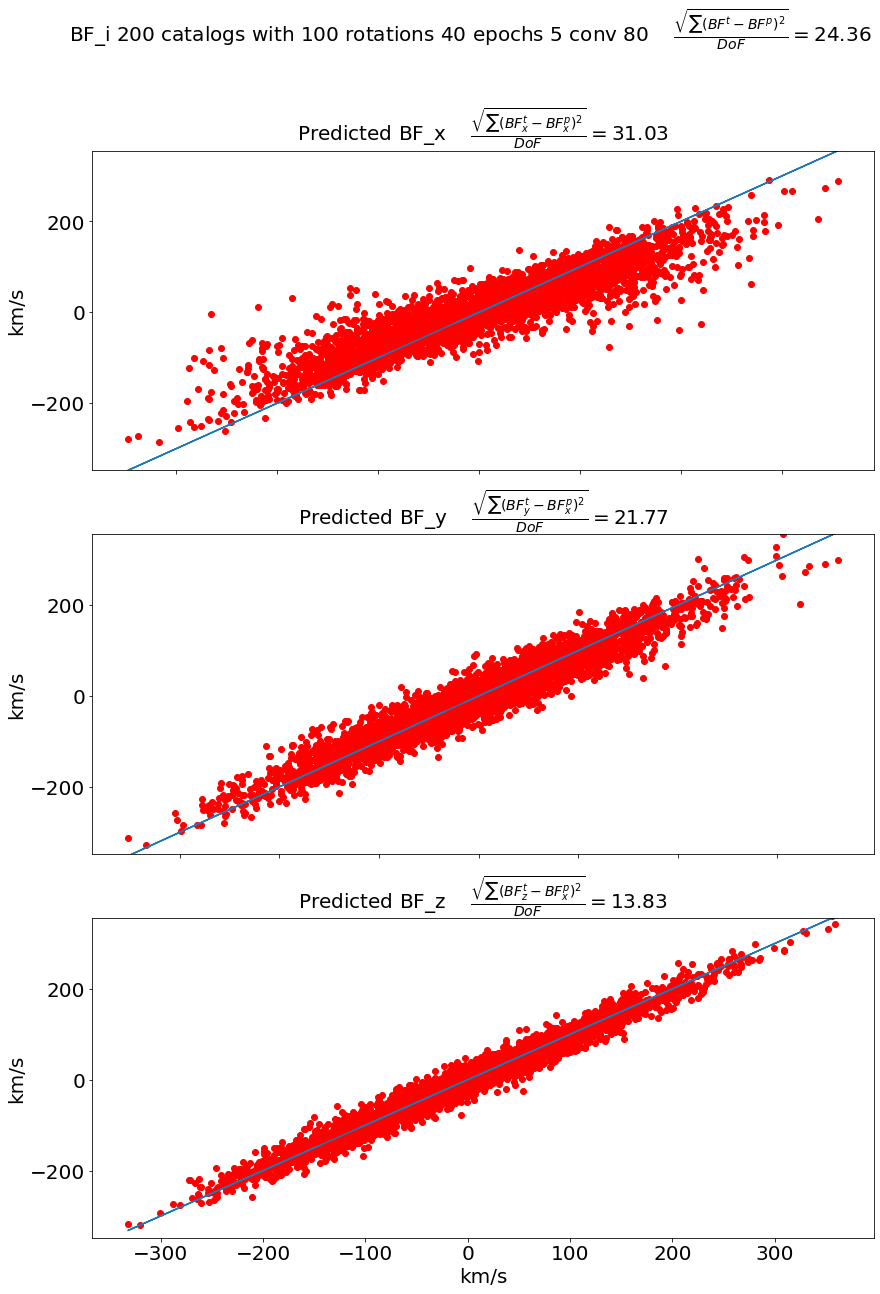

In [11]:

plt.rcParams['figure.figsize'] = [14, 20]
figure, axis = plt.subplots(3)

# put main title
figure.suptitle(label1_pre, fontsize=25)

# axis label size
for i in range(3):
    axis[i].tick_params(axis='x', labelsize=20)
    axis[i].tick_params(axis='y', labelsize=20)

y_limit = [min(y_test[:,0]*bf_max), max(y_test[:,0]*bf_max)]
axis[0].set_ylim(y_limit)
axis[1].set_ylim(y_limit)
axis[2].set_ylim(y_limit)

axis[0].plot(y_test[:,0]*bf_max,y_pred[:,0]*bf_max,'ro')
axis[0].plot(y_test[:,0]*bf_max,y_test[:,0]*bf_max)

labelx = 'Predicted BF_x' + '    ' + labx
axis[0].set_title(labelx, fontsize = 20)
axis[0].axes.xaxis.set_ticklabels([])
axis[0].set_ylabel('km/s', fontsize = 20)

axis[1].plot(y_test[:,1]*bf_max,y_pred[:,1]*bf_max,'ro')
axis[1].plot(y_test[:,1]*bf_max,y_test[:,1]*bf_max)

labely = 'Predicted BF_y' + '    ' + laby
axis[1].set_title(labely, fontsize = 20)
axis[1].axes.xaxis.set_ticklabels([])
axis[1].set_ylabel('km/s', fontsize = 20)

axis[2].plot(y_test[:,2]*bf_max,y_pred[:,2]*bf_max,'ro')
axis[2].plot(y_test[:,2]*bf_max,y_test[:,2]*bf_max)

labelz = 'Predicted BF_z' + '    ' + labz
axis[2].set_title(labelz, fontsize = 20)
axis[2].set_xlabel('km/s', fontsize = 20)
axis[2].set_ylabel('km/s', fontsize = 20)

labfig = label1_BF + '    ' + lab1
figure.suptitle(labfig, fontsize=20)
plt.savefig('Plots/' + label1_pre + '.png')



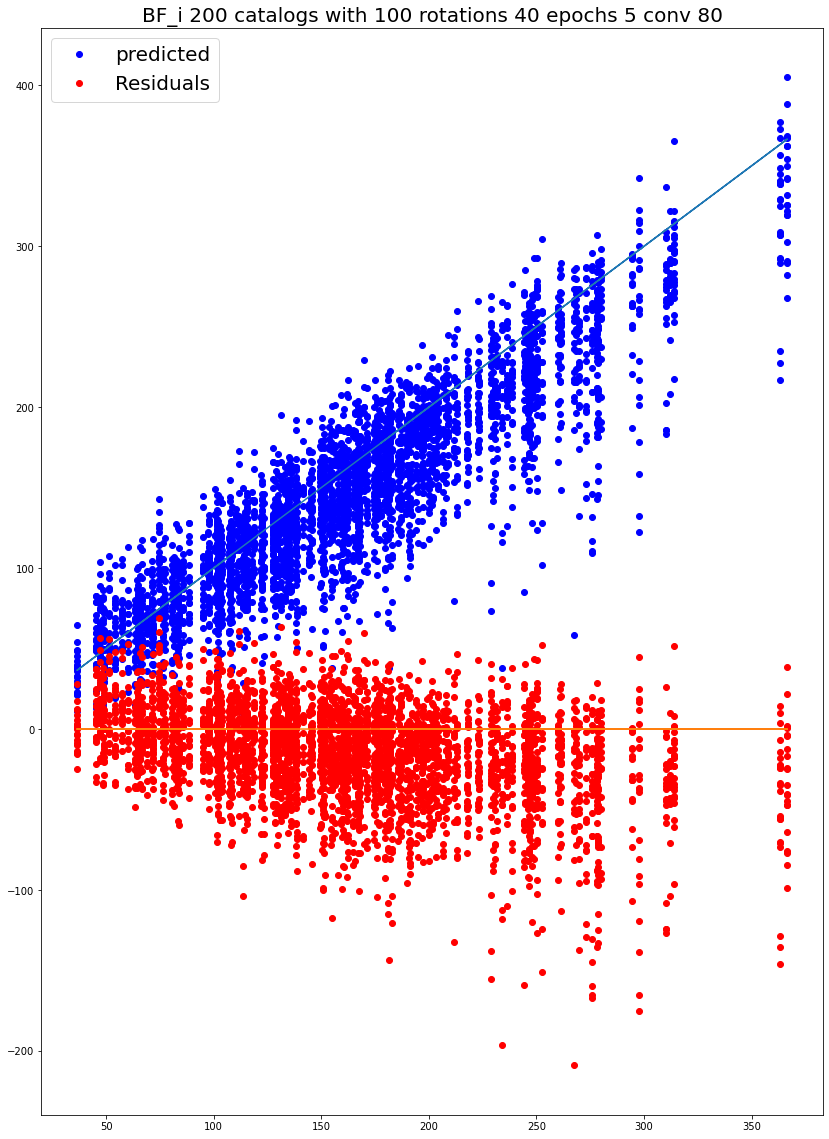

BF res = [-209.02 ,  68.82] BF value = [ 36.47, 366.54]


In [12]:
# Plot total BF 

if iplot == 0:

    plt.plot(bulkflows_true,bulkflows_pred,'bo', label='predicted')
    plt.plot(bulkflows_true,bulkflows_true)
    plt.plot(bulkflows_true,bulkflows_pred - bulkflows_true,'ro', label='Residuals')
    plt.plot(bulkflows_true,bulkflows_true - bulkflows_true)
    plt.legend(loc='upper left', fontsize = 20)
    plt.title(label1_BF, fontsize = 20)
    plt.show()
    print(f'BF res = [%6.2f , %6.2f] BF value = [%6.2f, %6.2f]' %
          (min(bulkflows_pred - bulkflows_true), 
           max(bulkflows_pred - bulkflows_true), 
           min(bulkflows_true), 
           max(bulkflows_true)))


In [13]:
# Plot BF ij residuals

if iplot == 2:

    plt.rcParams['figure.figsize'] = [14, 7]

    #plt.ylim(y_limit)
    plt.plot(bulkflows_true_xy, bulkflows_pred_xy - bulkflows_true_xy,'ro')
    plt.plot(bulkflows_true_xy, bulkflows_true_xy - bulkflows_true_xy)
    plt.title('xy - ' + label1_res)
    plt.xlabel('km/s')
    plt.ylabel('km/s')

    plt.show()

    #plt.ylim(y_limit)
    plt.plot(bulkflows_true_xz, bulkflows_pred_xz - bulkflows_true_xz,'ro')
    plt.plot(bulkflows_true_xz, bulkflows_true_xz - bulkflows_true_xz)
    plt.title('xz - ' + label1_res)
    plt.xlabel('km/s')
    plt.ylabel('km/s')

    plt.show()

    #plt.ylim(y_limit)
    plt.plot(bulkflows_true_yz, bulkflows_pred_yz - bulkflows_true_yz,'ro')
    plt.plot(bulkflows_true_yz, bulkflows_true_yz - bulkflows_true_yz)
    plt.title('yz - ' + label1_res)
    plt.xlabel('km/s')
    plt.ylabel('km/s')

    plt.show()


In [14]:
print("%d catalogs %d rotations, finished in %6.2f s CPU  %6.2f s" % 
      (num_cat, num_rot,
       process_time() - start_process, time() - start_time))
GPUtil.showUtilization()

200 catalogs 100 rotations, finished in 1252.09 s CPU  6755.25 s
| ID | GPU | MEM |
------------------
